In [ ]:
"""
A fully connected neural network for Cold-formed Steel (CFS) Fastener Connection Backbone Prediction
Created on 12/05/2023
@author: Zhidong Zhang
"""

####################################
###  Loading necessary modules   ###
####################################

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch.utils.data as td
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from IPython import display
print("Libraries imported - ready to use PyTorch", torch.__version__)


Libraries imported - ready to use PyTorch 2.1.0+cu118


In [ ]:
####################################
###     Readin the Raw Data      ###
####################################

# Input Parameters: t1(mm), t2(mm), Fy1(Mpa), Fy2(Mpa), Fu1(Mpa), Fu2(Mpa), screw_diameter (mm) (1 and 2 imply two steel plies connected by a fastener)
# Output Parameters: t1(mm), t2(mm), Fy1(Mpa), Fy2(Mpa), Fu1(Mpa), Fu2(Mpa), screw_diameter (mm) (The four-point backbone parameters:(D1, P1),(D2, P2),(D3, P3),(D4, P4), P1=40%*P3, P2=80%*P3, P4=10%*P3)

url='https://raw.githubusercontent.com/EngineerWithData/FastenerNeuralNetwork/main/Test_Central_Summary_All.csv'
df = pd.read_csv(url, encoding = 'unicode_escape')
line_num = 93 # Num of lines inlcuded
x_raw = torch.tensor([df['t1'].head(line_num), df['t2'].head(line_num), df['Fy1'].head(line_num), df['Fy2'].head(line_num), df['Fu1'].head(line_num), df['Fu2'].head(line_num), df['screw_diameter'].head(line_num)])
x_raw = torch.transpose(x_raw, 0, 1)
y_raw = torch.tensor([df['D1'].head(line_num), df['D2'].head(line_num), df['D3'].head(line_num), df['D4'].head(line_num), df['P3'].head(line_num)])
y_raw = torch.transpose(y_raw, 0, 1)
x = x_raw.to(torch.float32)
y = y_raw.to(torch.float32)

## Normalize the input data ##
x_mean = torch.mean(x, dim=0)
x_var = torch.var(x, dim=0)
x_normalized = (x - x_mean)/torch.sqrt(x_var)
y_mean = torch.mean(y, dim=0)
y_var = torch.var(y, dim=0)
y_normalized = (y - y_mean)/torch.sqrt(y_var)

In [ ]:
####################################
###  Define the neural network   ###
####################################
input_size=7  # Number of input layer nodes
hidden_size=30 # Number of hidden layer nodes
output_size=5  # Number of output layer nodes

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        #return F.log_softmax(x)
        #return F.sigmoid(x)
        return x
## Create a model instance based on the neural network class
model = NeuralNetwork(input_size, hidden_size, output_size)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=7, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=30, bias=True)
  (fc5): Linear(in_features=30, out_features=30, bias=True)
  (fc6): Linear(in_features=30, out_features=5, bias=True)
)


Input Parameters: t1(mm), t2(mm), Fy1(Mpa), Fy2(Mpa), Fu1(Mpa), Fu2(Mpa), screw_diameter (mm)
New sample: tensor([[3.1000e-01, 1.4700e+00, 3.3242e+02, 3.5463e+02, 4.1584e+02, 4.6624e+02,
         4.7600e+00]])
Output Parameters: D1(mm) D2(mm) D3(mm) D4(mm) P3(N)
Prediction: tensor([[6.1775e-02, 1.1427e-01, 1.1700e+00, 1.2719e+01, 1.2705e+03]])


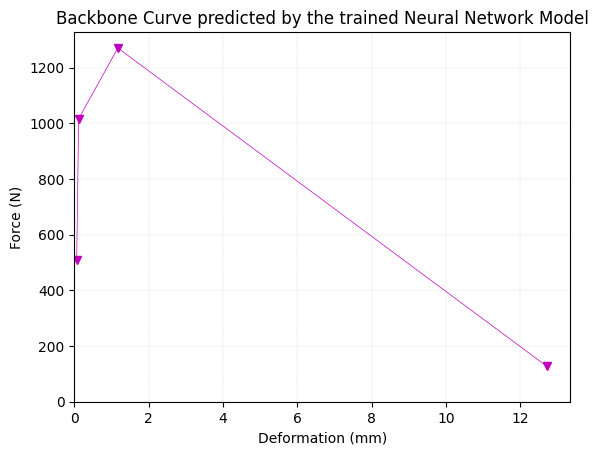

In [14]:
###################################################################
#####     Use the trained NN model for Backbone prediction    #####
###################################################################


###########################################################################################################################
############## Input Parameters: t1(mm), t2(mm), Fy1(Mpa), Fy2(Mpa), Fu1(Mpa), Fu2(Mpa), screw_diameter (mm) ##############
###########################################################################################################################
# New input features
x_new = torch.tensor([[0.31, 1.47,  332.42, 354.63,  415.84, 466.24, 4.76]])
# Normalized input
x_new_normalized = (x_new - x_mean)/torch.sqrt(x_var)
print('Input Parameters: t1(mm), t2(mm), Fy1(Mpa), Fy2(Mpa), Fu1(Mpa), Fu2(Mpa), screw_diameter (mm)')
print ('New sample: {}'.format(x_new))

# Create a new model class and load weights and bias
input_size=7  # Number of input layer nodes
hidden_size=30 # Number of hidden layer nodes
output_size=5  # Number of output layer nodes
model = NeuralNetwork(input_size, hidden_size, output_size)

# Note that reading the Pytorch Tensor data file "xxx.pt" from github to google colab does not work using the normal way:
# url='https://raw.githubusercontent.com/EngineerWithData/FastenerNeuralNetwork/main/net_try.pt' and torch.load(url)
# This is because the torch.load() has special requirements: we need to firstly read the file in into a buffer "data" and then readin the buffer directly
from io import BytesIO
import requests
response =requests.get ('https://raw.githubusercontent.com/EngineerWithData/FastenerNeuralNetwork/main/net_try.pt')
data = BytesIO(response.content)

# Load the buffer style "data"
model.load_state_dict(torch.load(data))

# Set model to evaluation mode
model.eval()

# Get a prediction for the new data sample
x_input = torch.Tensor(x_new_normalized).float()
predicted = model(x_input).data

###################################################################################
##############  Output Parameters: D1(mm) D2(mm) D3(mm) D4(mm) P3(N) ##############
###################################################################################
# Output Parameters: D1(mm) D2(mm) D3(mm) D4(mm) P3(N)
# Denormalized Output
predicted_Denormalized=(predicted*(torch.sqrt(y_var))+y_mean)
print('Output Parameters: D1(mm) D2(mm) D3(mm) D4(mm) P3(N)')
print('Prediction:', predicted_Denormalized)

# Plot the Backbone Curve predicted by the trained NN model
fig, ax = plt.subplots()
Predicted1=predicted_Denormalized.numpy()
ax.plot([Predicted1[0][0],Predicted1[0][1],Predicted1[0][2],Predicted1[0][3]], [Predicted1[0][4]*0.4,Predicted1[0][4]*0.8,Predicted1[0][4],Predicted1[0][4]*0.1], 'v-m', linewidth=0.5)
plt.title('Backbone Curve predicted by the trained Neural Network Model')
ax.set_xlabel("Deformation (mm)") # SI units axis x and y
ax.set_ylabel("Force (N)")
ax.set_xlim(xmin=0) # set the x axis limit from 0
ax.set_ylim(ymin=0) # set the y axis limit from 0
ax.grid(linestyle="--", color='grey', linewidth=0.1) # set up the grid style